In [3]:
import torch.nn as nn
class Reslock(nn.Module):
     def __init__(self, in_channels, out_channels, stride=1):
         super(Reslock, self).__init__()

        
         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
         self.bn1 = nn.BatchNorm2d(out_channels)
         self.relu = nn.ReLU(inplace=True)

         
         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
         self.bn2 = nn.BatchNorm2d(out_channels)

         if in_channels != out_channels:
            self.downsample = nn.Sequential(
                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
                 nn.BatchNorm2d(out_channels)
             )
         else:
            
             self.downsample = None

     def forward(self, x):
         identity = x

         out = self.conv1(x)
         out = self.bn1(out)
         out = self.relu(out)

         out = self.conv2(out)
         out = self.bn2(out)

         if self.downsample is not None:
             identity = self.downsample(x)

         out += identity
         out = self.relu(out)

         return out





class ResNet34(nn.Module):
     def __init__(self, num_classes=10):
         super(ResNet34, self).__init__()

         
         self.first = nn.Sequential(
             
             nn.Conv2d(1, 64, 7, 2, 3),
             nn.BatchNorm2d(64),
             nn.ReLU(inplace=True),

            
             nn.MaxPool2d(3, 1, 1)
         )

        
         self.layer1 = self.make_layer(64, 64, 3, 1)

       
         self.layer2 = self.make_layer(64, 128, 4, 2)  
         self.layer3 = self.make_layer(128, 256, 6, 2)  
         self.layer4 = self.make_layer(256, 512, 3, 2)

         self.avg_pool = nn.AvgPool2d(2)  
         self.fc = nn.Linear(512, num_classes)

     def make_layer(self, in_channels, out_channels, block_num, stride):
         layers = []

         
         layers.append(Reslock(in_channels, out_channels, stride))

        
         for i in range(block_num - 1):
             layers.append(Reslock(out_channels, out_channels, 1))

         return nn.Sequential(*layers)

     def forward(self, x):
         x = self.first(x)
         x = self.layer1(x)
         x = self.layer2(x)
         x = self.layer3(x)
         x = self.layer4(x)
         x = self.avg_pool(x)

         # x.size()[0]: batch size
         x = x.view(x.size()[0], -1)
         x = self.fc(x)
         return x

Finished reading data


<ipython-input-6-fb2d4145fbe1>:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).type(torch.FloatTensor).cuda()
<ipython-input-6-fb2d4145fbe1>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target).type(torch.LongTensor).cuda()
<ipython-input-6-fb2d4145fbe1>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data).type(torch.FloatTensor).cuda()
<ipython-input-6-fb2d4145fbe1>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().

Epoch1 iteration9/469: Accuracy = 11.82% Loss_train = 0.014172847382724285 Loss_test = 0.0023072645425796508
Epoch1 iteration19/469: Accuracy = 11.5% Loss_train = 0.0063394480384886265 Loss_test = 0.002266434621810913
Epoch1 iteration29/469: Accuracy = 54.1% Loss_train = 0.0027406462468206882 Loss_test = 0.0014705371141433717
Epoch1 iteration39/469: Accuracy = 92.02% Loss_train = 0.002110554138198495 Loss_test = 0.0003689762115478516
Epoch1 iteration49/469: Accuracy = 95.07% Loss_train = 0.000956673757173121 Loss_test = 0.0001815327122807503
Epoch1 iteration59/469: Accuracy = 95.69% Loss_train = 0.0007732079247944057 Loss_test = 0.0001484194442629814
Epoch1 iteration69/469: Accuracy = 96.17999999999999% Loss_train = 0.0012676190817728639 Loss_test = 0.00013335872665047645
Epoch1 iteration79/469: Accuracy = 96.73% Loss_train = 0.0006444393075071275 Loss_test = 0.00011601673141121864
Epoch1 iteration89/469: Accuracy = 96.6% Loss_train = 0.0010728449560701847 Loss_test = 0.000121509480476

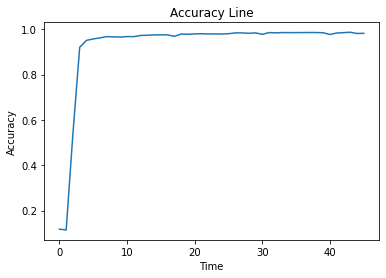

In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# paremeters
momentum = 0.9
record_step = 10
batch_size = 128
test_batch_size = 1000
lr = 0.001
Epoch = 1

# test
def test(test_loader, net, loss_function):
    net.eval()
    total_loss = 0
    correct = 0
    for data, target in test_loader:
        data = torch.tensor(data).type(torch.FloatTensor).cuda()
        target = torch.tensor(target).type(torch.LongTensor).cuda()
        out = net(data)
        loss = loss_function(out, target)
        classification = torch.max(out,1)[1]
        total_loss += loss.item()
        correct += (target == classification).sum()

    return total_loss/len(test_loader.dataset), correct.item()/len(test_loader.dataset)


# train
def main():
    # load dataset
    train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=test_batch_size, shuffle=True)
    print('Finished reading data')

    # load net
    net = ResNet34().cuda()
    loss_function = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # train
    max_accuracy = 0
    accuracy_list = []
    for epoch in range(Epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            net.train()
            data = torch.tensor(data).type(torch.FloatTensor).cuda()
            target = torch.tensor(target).type(torch.LongTensor).cuda()
            out = net(data)
            classification = torch.max(out,1)[1]
            optimizer.zero_grad()
            loss = loss_function(out, target)
            loss.backward()
            optimizer.step()

            if (batch_idx+1)%(record_step) == 0:
                test_loss, accuracy = test(test_loader, net, loss_function)
                accuracy_list.append(accuracy)
                # save the best model
                if accuracy >= max_accuracy:
                    torch.save(net, './net.pkl')
                print(f'Epoch{epoch+1} iteration{batch_idx}/{len(train_loader)}: Accuracy = {accuracy*100.}% '
                      f'Loss_train = {loss.item()/len(data)} Loss_test = {test_loss}')

    print('Finished all!')
    # figure
    plt.plot(accuracy_list)
    plt.title('Accuracy Line')
    plt.xlabel('Time')
    plt.ylabel('Accuracy')
    plt.savefig("pic.png")
    # plt.show()


if __name__ == '__main__':
    main()
